# **Improving the Convolutional Neural Network**

To achieve better results, the following changes were made to the training process:

- Modified the neural network architecture by adding one more dropout layer (set to 0.3), three additional convolutional layers, and one extra fully connected layer.

- Adjusted the training strategy:

  - The first 10 epochs were trained on lightly augmented data.
  - This was followed by 25 epochs on strongly augmented data.
  - Then, 10 more epochs with light augmentation.
  - Another 10 epochs with light augmentation, but with the learning rate reduced to 0.0001.
  - Then, 7 epochs with a learning rate of 0.00005.
  - Finally, 7 epochs with a learning rate of 0.00001.

In sum, there was 69 epochs.

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np

In [ ]:
translate = {"cane": "dog", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo", "ragno": "spider"}

def translate_class(class_name):
    return translate[class_name] if class_name in translate else class_name

In [ ]:
# light augmentation
transform_train_data = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.51775634, 0.5003316, 0.41256544], [0.271141, 0.26631165, 0.28339595])
])

In [ ]:
# strong augmentation
transform_train_data = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.51775634, 0.5003316, 0.41256544], [0.271141, 0.26631165, 0.28339595])

])

In [ ]:
batch_size = 128
random_seed = 42
dataset_path = '/kaggle/input/animals-10/raw-img'

transform_test_data = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.51775634, 0.5003316, 0.41256544], [0.271141, 0.26631165, 0.28339595])
])

full_dataset = datasets.ImageFolder(root=dataset_path)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_ds = Subset(datasets.ImageFolder(root=dataset_path, transform=transform_train_data), train_dataset.indices)
val_ds = Subset(datasets.ImageFolder(root=dataset_path, transform=transform_train_data), val_dataset.indices)
test_ds = Subset(datasets.ImageFolder(root=dataset_path, transform=transform_test_data), test_dataset.indices)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size * 2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=4, pin_memory=True)

torch.manual_seed(random_seed)
print(f'Train size: {train_size}. Val size: {val_size}. Test size: {test_size}')

Train size: 18325. Val size: 2617. Test size: 5237


In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d(1)

        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [ ]:
def check_accuracy(loader, model):
    """
    Checks the accuracy of the model on the given dataset loader.
    """
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        # calculate accuracy
        accuracy = float(num_correct) / float(num_samples) * 100
        return accuracy


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN(num_classes=10).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# changing learning rate manually
for g in optimizer.param_groups:
    g['lr'] = 0.00001

# Training model

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

learning_rates = []
epochs_happened = 0

In [ ]:
# train neural network

for epoch in range(2):
    epochs_happened += 1

    model.train()
    running_loss = 0.0

    for batch_index, (images, labels) in enumerate(train_dl):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dl)
    epoch_accuracy = check_accuracy(train_dl, model)

    # save for later
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch {epochs_happened}\nTraining loss: {epoch_loss:.4f}\nAccuracy on train set: {epoch_accuracy:.4f}')


    # on validation set
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
         for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()


    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    val_accuracy = check_accuracy(val_dl, model)
    val_accuracies.append(val_accuracy)

    print(f'Validation loss: {val_loss:.4f}')
    print(f'Accuracy on validation set: {val_accuracy:.4f}')
    print()

Epoch 68
Training loss: 0.1054
Accuracy on train set: 97.3151
Validation loss: 0.3397
Accuracy on validation set: 90.0267

Epoch 69
Training loss: 0.1043
Accuracy on train set: 97.6480
Validation loss: 0.3520
Accuracy on validation set: 89.9885



# Analyzing model training and performance

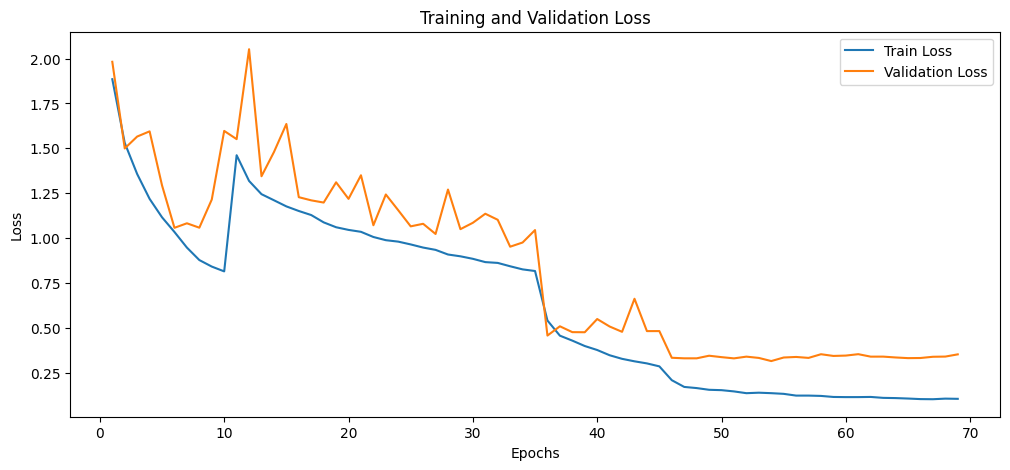

In [ ]:
epochs = range(1, epochs_happened + 1)
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

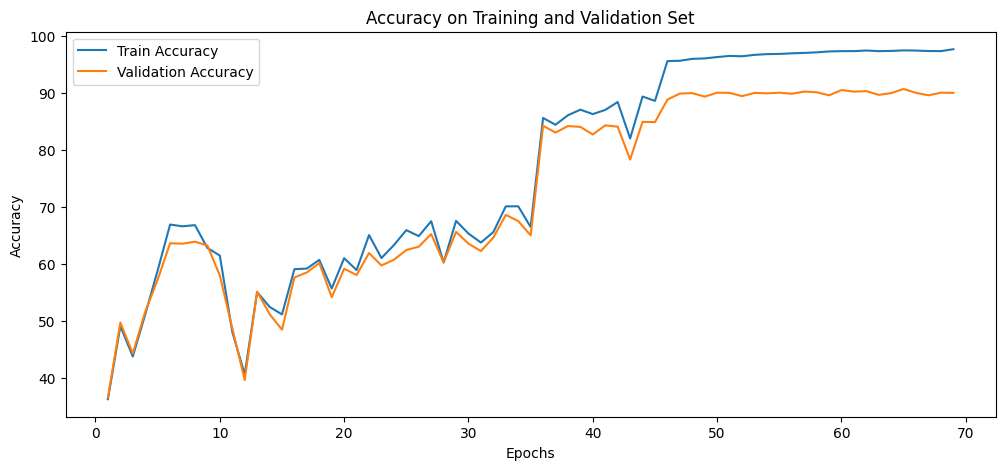

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy on Training and Validation Set')
plt.legend()

plt.show()

**Evaluating model performance**

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)
f1 = f1_score(all_labels, all_preds, average=None)
conf_matrix = confusion_matrix(all_labels, all_preds)

overall_f1_weighted = f1_score(all_labels, all_preds, average="weighted")


class_names = full_dataset.classes
for i in range(len(class_names)):
    class_names[i] = translate_class(class_names[i])

print(f"Accuracy: {accuracy:.4f}")
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f"Class {class_names[i]} -> Precision: {p:.4f}, Recall: {r:.4f}, F1-score: {f:.4f}")

print()
print(f"Overall F1-score (Weighted): {overall_f1_weighted:.4f}")

Accuracy: 0.9043
Class dog -> Precision: 0.8689, Recall: 0.9034, F1-score: 0.8858
Class horse -> Precision: 0.8813, Recall: 0.9065, F1-score: 0.8937
Class elephant -> Precision: 0.8908, Recall: 0.8785, F1-score: 0.8846
Class butterfly -> Precision: 0.9273, Recall: 0.9027, F1-score: 0.9148
Class chicken -> Precision: 0.9615, Recall: 0.9322, F1-score: 0.9466
Class cat -> Precision: 0.8724, Recall: 0.8750, F1-score: 0.8737
Class cow -> Precision: 0.8418, Recall: 0.8398, F1-score: 0.8408
Class sheep -> Precision: 0.8567, Recall: 0.8496, F1-score: 0.8531
Class spider -> Precision: 0.9560, Recall: 0.9611, F1-score: 0.9585
Class squirrel -> Precision: 0.9358, Recall: 0.8883, F1-score: 0.9115

Overall F1-score (Weighted): 0.9045


Results:

Accuracy: 0.9043

Scores for each class:

Class dog -> Precision: 0.8689, Recall: 0.9034,       F1-score: 0.8858

Class horse -> Precision: 0.8813, Recall: 0.9065,     F1-score: 0.8937

Class elephant -> Precision: 0.8908, Recall: 0.8785,  F1-score: 0.8846

Class butterfly -> Precision: 0.9273, Recall: 0.9027, F1-score: 0.9148

Class chicken -> Precision: 0.9615, Recall: 0.9322,   F1-score: 0.9466

Class cat -> Precision: 0.8724, Recall: 0.8750,       F1-score: 0.8737

Class cow -> Precision: 0.8418, Recall: 0.8398,       F1-score: 0.8408

Class sheep -> Precision: 0.8567, Recall: 0.8496,     F1-score: 0.8531

Class spider -> Precision: 0.9560, Recall: 0.9611,    F1-score: 0.9585

Class squirrel -> Precision: 0.9358, Recall: 0.8883,  F1-score: 0.9115


Overall F1-score (Weighted): 0.9045

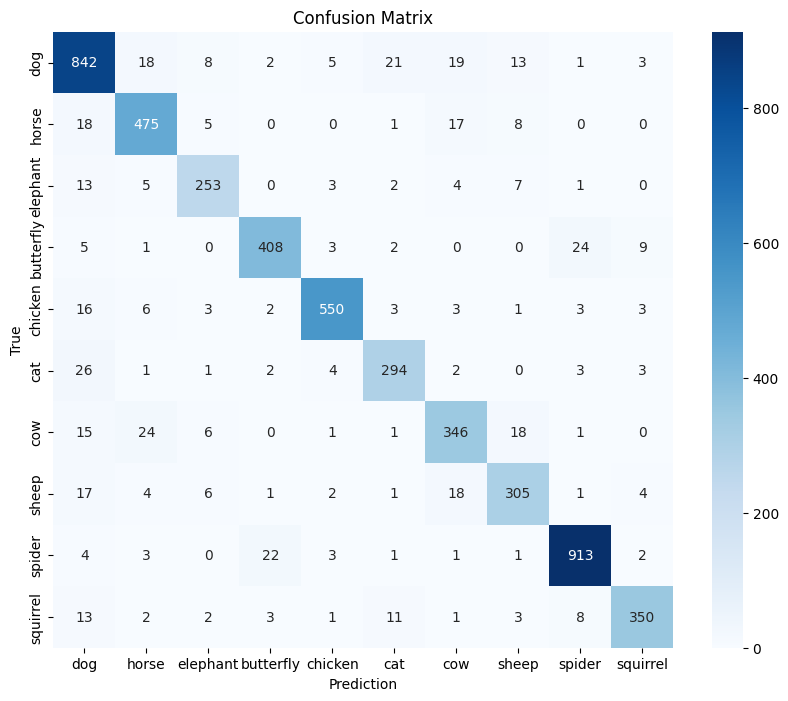

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Prediction")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

**Saving model for further usage**

In [ ]:
model_path = '/kaggle/working/animal_classifier.pth'
torch.save(model, model_path)

In [ ]:
model_path = '/kaggle/working/animal_classifier_two.pth'
torch.save({
            'epoch': epochs_happened,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'model_checkpoint.tar')